In [1]:
!pip install gensim seaborn wordcloud rank_bm25 nltk
!pip install git+https://github.com/lambdaofgod/mlutil

  Cloning https://github.com/lambdaofgod/mlutil to /tmp/pip-req-build-g1bcqamv


  Stored in directory: /tmp/pip-ephem-wheel-cache-0wgre_iz/wheels/42/32/46/9616d5dd85e5dbc05ce3816dfa7dcedc052bc8b29442e1766a
Successfully built mlutil


In [2]:
import re
import tqdm
import requests

import numpy as np

from markdown import markdown
import nltk


import pandas as pd
from pandas.io.json import json_normalize
from gensim import summarization

from sklearn import decomposition, feature_extraction, manifold
from sklearn.feature_extraction import stop_words
from sklearn import pipeline

import rank_bm25

from mlutil import topic_modeling

import seaborn as sns
import wordcloud

import matplotlib.pyplot as plt
from IPython.display import Markdown, display

import bokeh.model
import bokeh.plotting
import bokeh.io

bokeh.io.output_notebook()

/etc/anaconda/envs/ml/lib/python3.8/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


Loading BokehJS ...

In [3]:
plt.style.use('dark_background')

In [4]:
def printmd(string):
    display(Markdown(string))
    

def get_word_cloud(texts):
    text = ' '.join(texts)
    return wordcloud.WordCloud(max_font_size=40).generate(text)


def show_word_cloud(wc, figure_kwargs={'figsize': (8, 5)}):
    plt.figure(**figure_kwargs)
    plt.imshow(wc)
    plt.axis('off')
    plt.show()

  
def show_word_cloud_from_texts(text_column):
    texts = text_column.fillna('').values
    cloud = get_word_cloud(texts)
    show_word_cloud(cloud)

Put your Github token to `github_auth_key.txt`

You have to do this because, unfortunately, for now there is no way to use GraphQL without authentication.

In [5]:
key = open('github_auth_key.txt', 'r').read().strip()

Note that I barely know GraphQL: I made this query in [Github's API explorer](https://developer.github.com/v4/explorer/)

In [6]:
headers = {'Authorization': 'token ' + key}


def run_query(query): # A simple function to use requests.post to make the API call. Note the json= section.
    request = requests.post('https://api.github.com/graphql', json={'query': query}, headers=headers)
    if request.status_code == 200:
        return request.json()
    else:
        raise Exception("Query failed to run by returning code of {}. {}".format(request.status_code, query))

        
# The GraphQL query (with a few aditional bits included) itself defined as a multi-line string.       
def get_next_paged_result(result):
  if result is None:
    end_cursor_string = ''
  else:
    end_cursor_string = 'after: "{}"'.format(result['data']['viewer']['starredRepositories']['pageInfo']['endCursor'])
  new_query_string = """{{
    viewer {{
      starredRepositories(first: 100, {}) {{
        pageInfo {{
          startCursor
          hasNextPage
          endCursor
        }}
        nodes {{
          name
          owner {{
            login
          }}
          description
          primaryLanguage {{
            name
          }}
          repositoryTopics(first: 10) {{
            nodes {{
              topic {{
                name
              }}
            }}
          }}
          object(expression: "master:README.md") {{
            ... on Blob {{
              text
            }}
          }}
        }}
      }}
    }}
  }}""".format(end_cursor_string)
  return run_query(new_query_string)

In [7]:
def get_starred_repo_information():
    next_result = None
    starred_repo_information = []
    for __ in tqdm.tqdm(range(5)):
      next_result = get_next_paged_result(next_result)
      starred_repo_information = starred_repo_information + next_result['data']['viewer']['starredRepositories']['nodes']
    return starred_repo_information

In [8]:
starred_repo_information = get_starred_repo_information()

100%|██████████| 5/5 [00:17<00:00,  3.55s/it]


In [9]:
def get_cleaned_starred_repositories_df(repo_information, stemmer=nltk.stem.PorterStemmer()):
    repo_df = json_normalize(repo_information)
    repo_df.index = repo_df['name']
    repo_df.drop('name', axis=1, inplace=True)
    repo_df['primaryLanguage'] = repo_df['primaryLanguage.name']
    repo_df.drop('primaryLanguage.name', axis=1)
    repo_df['topics'] = repo_df['repositoryTopics.nodes'].apply(lambda recs: [r['topic']['name'] for r in recs])
    repo_df['topics'] = repo_df['topics'].apply(lambda ts: [stemmer.stem(t) for t in ts])
    repo_df['description'].fillna('', inplace=True)
    repo_df['description'] = repo_df['description'].str.lower().apply(stemmer.stem)
    repo_df['description_keywords'] = repo_df['description'].apply(summarization.keywords)
    return repo_df

In [10]:
def get_topic_representant_indices(topic_weights, topic_idx, num_representants=5):
    indices = topic_weights[:, topic_idx].argsort()[::-1]
    return indices[:num_representants]


def get_repos_representing_topic(repo_df, topic_weights, topic_idx, num_representants=5):
    return repo_df.iloc[get_topic_representant_indices(topic_weights, topic_idx, num_representants)]

In [11]:
starred_repo_df = get_cleaned_starred_repositories_df(starred_repo_information)

Primary language

In [12]:
language_counts = starred_repo_df['primaryLanguage'].fillna('unspecified').value_counts()

In [13]:
p = bokeh.plotting.figure(x_range=list(language_counts.index), title='Repository number by language')

p.vbar(x=language_counts.index, top=language_counts, width=1)
p.xaxis.major_label_orientation = "vertical"
bokeh.plotting.show(p)

In [14]:
description_lengths = starred_repo_df['description'].str.split().apply(lambda l: 0 if l is None else len(l))

In [15]:
description_lengths = starred_repo_df['description'].str.split().apply(lambda l: 0 if l is None else len(l))

hist, edges = np.histogram(description_lengths.values, bins=25)
median_description_length = description_lengths.median()
mean_description_length = description_lengths.mean()

p = bokeh.plotting.figure(
    title='Description length',
    x_axis_label='words in description',
    y_axis_label='number of repositories',
    plot_height=600, plot_width=800)
p.quad(top=hist, left=edges[:-1], right=edges[1:], bottom=0)
p.line([median_description_length, median_description_length], [0, 140], line_color='red')
bokeh.plotting.show(p)

Topics word cloud

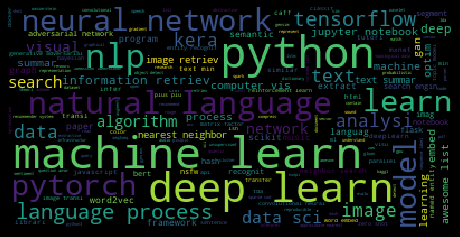

In [16]:
show_word_cloud_from_texts(starred_repo_df['topics'].apply(' '.join))

Descriptions word cloud

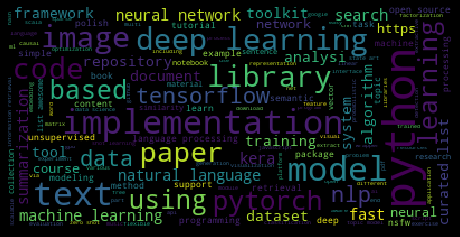

In [17]:
show_word_cloud_from_texts(starred_repo_df['description'])

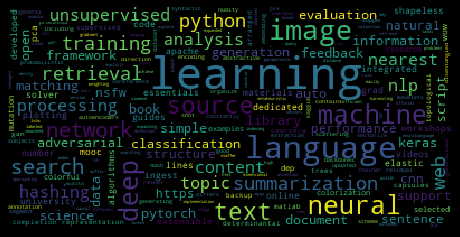

In [18]:
show_word_cloud_from_texts(starred_repo_df['description_keywords'])

## Term-document matrix

In [19]:
vectorizer = feature_extraction.text.TfidfVectorizer(
    stop_words=stop_words.ENGLISH_STOP_WORDS,
    ngram_range=(1,2)
)
term_document_matrix = vectorizer.fit_transform(starred_repo_df['description'])

## Topic modeling (repo descriptions)

Note that term-document matrix is nonnegative - it contains (normalized) counts of words in documents.

In general a method that models documents as combinations of 'topics' which are combination of words is called a topic model.

One of the simplest ways to capture that is Nonnegative Matrix Factorization:

$$X \approx WH$$

Formally it solves minimization problem for

$$\|X - WH\|^2_F = \sum_{i, j}(X_{i,j} - (WH)_{i,j})^2 $$

Where $W$, $H$ are nonnegative.

In [20]:
num_topics = 10
nmf = decomposition.NMF(n_components=num_topics, alpha=0.01, l1_ratio=0.5)

In [21]:
reduced_term_document_matrix = nmf.fit_transform(term_document_matrix)

In [22]:
topic_words = topic_modeling.top_topic_words(nmf, vectorizer.get_feature_names(), 10)

In [23]:
top_words_per_topic = [list(topic_words.iloc[topic].values) for topic in range(num_topics)]
representative_repos = [get_repos_representing_topic(starred_repo_df, reduced_term_document_matrix, topic)[['description']] for topic in range(num_topics)]

## Topic keywords and most representative repositories

------
# Topic 1
------

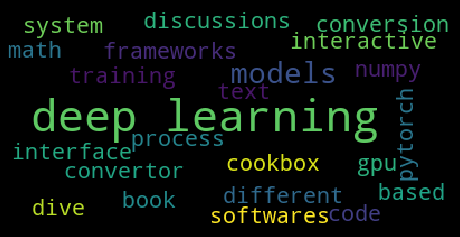

# Keywords

['deep',
 'deep learning',
 'learning',
 'models',
 'learning models',
 'cookbox',
 'learning cookbox',
 'learning hash',
 'program',
 'hash']

## **repositories representative for 1th topic:**

,description
name,
deep_learning_cookbook,deep learning cookbox
deep-learning-model-convertor,the convertor/conversion of deep learning mode...
DIGITS,deep learning gpu training system
d2l-en,dive into deep learning: an interactive deep l...
castor,pytorch deep learning models for text process


------
# Topic 2
------

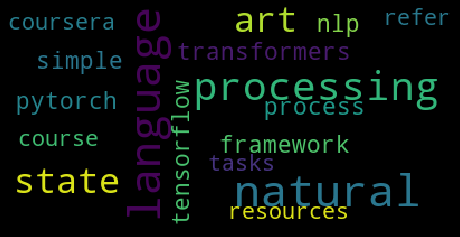

# Keywords

['language',
 'natural language',
 'natural',
 'processing',
 'language processing',
 'nlp',
 'state art',
 'state',
 'art',
 'art natural']

## **repositories representative for 2th topic:**

,description
name,
flair,a very simple framework for state-of-the-art n...
spark-nlp,state of the art natural language process
transformers,🤗 transformers: state-of-the-art natural langu...
natural-language-processing,"resources for ""natural language processing"" co..."
nlp_tasks,natural language processing tasks and refer


------
# Topic 3
------

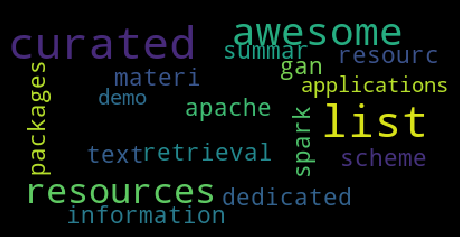

# Keywords

['list',
 'curated',
 'curated list',
 'awesome',
 'list awesome',
 'resources',
 'dedicated',
 'list resources',
 'resources dedicated',
 'tutorials']

## **repositories representative for 3th topic:**

,description
name,
awesome-scheme,a curated list of awesome scheme resources and...
awesome-text-summarization,a curated list of resources dedicated to text ...
awesome-spark,a curated list of awesome apache spark package...
awesome-information-retrieval,a curated list of awesome information retrieva...
gans-awesome-applications,curated list of awesome gan applications and demo


------
# Topic 4
------

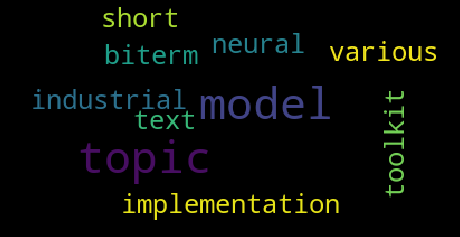

# Keywords

['model',
 'topic',
 'topic model',
 'neural',
 'neural topic',
 'toolkit',
 'biterm topic',
 'biterm',
 'various topic',
 'implementation various']

## **repositories representative for 4th topic:**

,description
name,
NeuralTopicModels,neural topic model
biterm,biterm topic model
python-topic-model,implementation of various topic model
Familia,a toolkit for industrial topic model
SeaNMF,short text topic model


------
# Topic 5
------

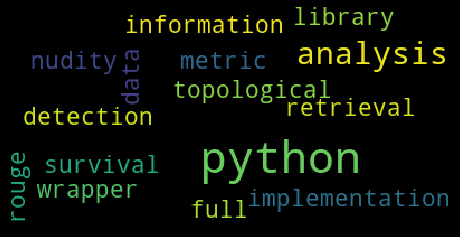

# Keywords

['python',
 'library',
 'analysis',
 'implementation',
 'python implementation',
 'algorithm',
 'analysis python',
 'wrapper',
 'factorization',
 'fast']

## **repositories representative for 5th topic:**

,description
name,
scikit-tda,topological data analysis for python🐍
lifelines,survival analysis in python
irlib,information retrieval library (in python)
nude.py,nudity detection with python
rouge,a full python implementation of the rouge metr...


------
# Topic 6
------

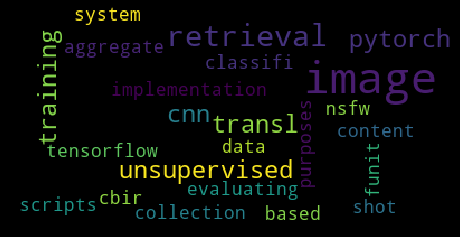

# Keywords

['image',
 'retrieval',
 'image image',
 'image retrieval',
 'image transl',
 'unsupervised image',
 'transl',
 'tensorflow',
 'unsupervised',
 'nsfw']

## **repositories representative for 6th topic:**

,description
name,
UNIT,unsupervised image-to-image transl
FUNIT_tensorflow,tensorflow implementation of funit: few-shot u...
CBIR,🏞 a content-based image retrieval (cbir) system
nsfw_data_scraper,collection of scripts to aggregate image data ...
cnnimageretrieval-pytorch,cnn image retrieval in pytorch: training and e...


------
# Topic 7
------

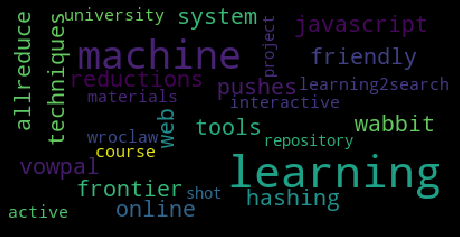

# Keywords

['machine',
 'machine learning',
 'learning',
 'tools',
 'tools javascript',
 'learning tools',
 'javascript',
 'materials',
 'learning web',
 'friendly machine']

## **repositories representative for 7th topic:**

,description
name,
ml,machine learning tools in javascript
ml5-library,friendly machine learning for the web! 🤖
vowpal_wabbit,vowpal wabbit is a machine learning system whi...
ml_uwr,materials for my machine learning course at un...
few-shot,repository for few-shot learning machine learn...


------
# Topic 8
------

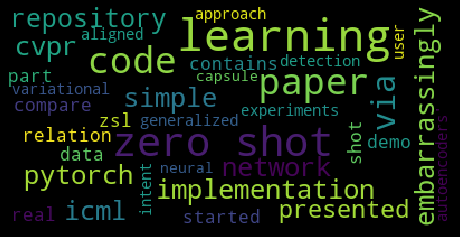

# Keywords

['shot',
 'shot learning',
 'zero shot',
 'zero',
 'code',
 'paper',
 'learning',
 'repository',
 'simple',
 'presented']

## **repositories representative for 8th topic:**

,description
name,
LearningToCompare_ZSL,pytorch code for cvpr 2018 paper: learning to ...
embarrassingly-simple-zero-shot-learning,this is a started/demo code for zero-shot-lear...
Embarrassingly-simple-ZSL,this repository contains the code for the real...
Generalized-Zero-Shot-Learning-via-Aligned-Variational-Autoencoders,this repository has the pytorch implementation...
ZeroShotCapsule,"code for paper ""zero-shot user intent detectio..."


------
# Topic 9
------

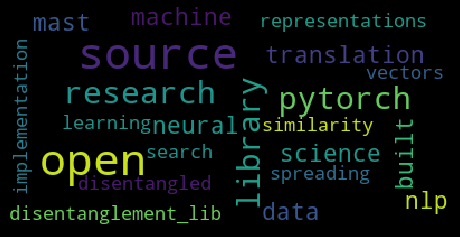

# Keywords

['open',
 'open source',
 'source',
 'data',
 'data science',
 'science',
 'pytorch',
 'research',
 'source data',
 'mast']

## **repositories representative for 9th topic:**

,description
name,
go,the open source data science mast
OpenNMT-py,open source neural machine translation in pytorch
allennlp,"an open-source nlp research library, built on ..."
disentanglement_lib,disentanglement_lib is an open-source library ...
spreadingvectors,"open source implementation of ""spreading vect..."


------
# Topic 10
------

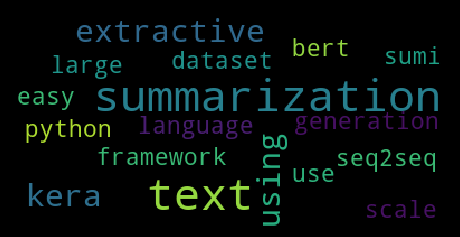

# Keywords

['text',
 'summarization',
 'text summarization',
 'extractive',
 'using',
 'extractive text',
 'summarization using',
 'bert',
 'summarization bert',
 'abstractive']

## **repositories representative for 10th topic:**

,description
name,
bert-extractive-summarizer,easy to use extractive text summarization with...
text-summarizer,python framework for extractive text summariza...
keras-text-summarization,text summarization using seq2seq in kera
WikiHow-Dataset,a large scale text summarization dataset
text-learning,language + text generation + summarization usi...


In [24]:
for topic in range(num_topics):
    printmd("""------\n# Topic {}\n------""".format(topic+1))
    show_word_cloud_from_texts(representative_repos[topic]['description'])
    printmd('# Keywords')
    display(top_words_per_topic[topic])
    printmd('## **repositories representative for {}th topic:**'.format(topic + 1))
    display(representative_repos[topic])
    print()

## Visualizing repository 2D projection

In [25]:
mds = manifold.MDS() 
mds_reduced_term_document_matrix = mds.fit_transform(reduced_term_document_matrix)

In [26]:
representatives = pd.concat(representative_repos)

In [27]:
representative_indices = np.where(starred_repo_df.index.isin(representatives.index))

In [28]:
mds_reduced_representative_vectors = mds_reduced_term_document_matrix[representative_indices]

In [29]:
x, y = mds_reduced_representative_vectors[:, 0], mds_reduced_representative_vectors[:, 1]
source_df = pd.DataFrame({'x': x, 'y': y, 'label': starred_repo_df.index[representative_indices]})

In [30]:
source = bokeh.models.ColumnDataSource(source_df)

TOOLS="hover,crosshair,pan,wheel_zoom,zoom_in,zoom_out,box_zoom,undo,redo,reset,tap,save,box_select,poly_select,lasso_select,"
p = bokeh.plotting.figure(tools=TOOLS)
p.scatter(x='x', y='y', source=source)


labels = bokeh.models.LabelSet(x='x', y='y', text='label', level='glyph',
              x_offset=5, y_offset=5, source=source, render_mode='canvas', text_font_size='7pt')
p.add_layout(labels)
bokeh.plotting.show(p)

# Search

In [31]:
import rank_bm25 


class SearchEngine:
    
    def __init__(self, df, bm25_cls=rank_bm25.BM25Okapi, text_col='text'):
        self.bm25 = bm25_cls(df[text_col].str.split())
        self.df = df
        
    def search(self, query, k=100):
        scores = self.bm25.get_scores(query.split())
        #scores = scores[scores > 0]
        relevant_indices = np.argsort(-scores)[:k]
        return self.df.iloc[relevant_indices[scores[relevant_indices] > 0]]

In [32]:
search_engine = SearchEngine(starred_repo_df, text_col='description')

In [33]:
search_engine.search('information retrieval')

,description,owner.login,primaryLanguage.name,repositoryTopics.nodes,object.text,primaryLanguage,object,topics,description_keywords
name,,,,,,,,,
irlib,information retrieval library (in python),gr33ndata,Python,[],NaN,Python,NaN,[],
awesome-information-retrieval,a curated list of awesome information retrieva...,harpribot,NaN,[],# Awesome Information Retrieval [![Awesome](ht...,NaN,NaN,[],information
LIRE,open source library for content based image re...,dermotte,Java,"[{'topic': {'name': 'image-retrieval'}}, {'top...",# LIRE - Lucene Image Retrieval\nLIRE (Lucene ...,Java,NaN,"[image-retriev, lire, multimedia]",source
pytrec_eval,pytrec_eval is an information retrieval evalua...,cvangysel,C++,"[{'topic': {'name': 'information-retrieval'}},...",pytrec_eval\n===========\n\npytrec\_eval is a ...,C++,NaN,"[information-retriev, evalu]",retrieval
query-expansion,developing different methods for expanding a q...,phosseini,Python,[],# query-expansion\n\nThis repository is dedica...,Python,NaN,[],different\nexpanding\nexpanded
SERT,semantic entity retrieval toolkit,cvangysel,Python,[{'topic': {'name': 'representation-learning'}...,Semantic Entity Retrieval Toolkit\n===========...,Python,NaN,"[representation-learn, deeplearn, neural-netwo...",
dit,python package for information theory.,dit,Python,"[{'topic': {'name': 'python'}}, {'topic': {'na...",NaN,Python,NaN,"[python, information-theori]",
ir-python,a python implementation for information retrie...,zxzlogic,Python,[],# ir-python\nA python implementation for infor...,Python,NaN,[],retrieval\npython\nindex\nindexing\nkey
cnnimageretrieval-pytorch,cnn image retrieval in pytorch: training and e...,filipradenovic,Python,"[{'topic': {'name': 'image-retrieval'}}, {'top...",## CNN Image Retrieval in PyTorch: Training an...,Python,NaN,"[image-retriev, convolutional-neural-network, ...",cnn\ncnns
